In [5]:
import sys
from pathlib import Path
# Get the repository root (2 levels up from current notebook)
repo_root = Path(__file__).parent.parent.parent if '__file__' in globals() else Path.cwd().parent.parent
sys.path.insert(0, str(repo_root))

# import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, trustworthiness
import Template
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier



In [6]:
Template = Template.Template()

# Build the path to the Excel file in the repository root
data_path = os.path.join(os.path.dirname(os.getcwd()), '..', 'Datos1_InteraccionesNIR.xlsx')


# import the data from all sheets of the Excel file

df1 = pd.read_excel(data_path, sheet_name=1)

In [3]:
print(df1['Tratamiento'].value_counts())

Tratamiento
Control       30
Fusarium      30
E_Hidrico     30
Ral_Fus       30
Fus_EH        30
Ral_EH        30
Fus_EH_Ral    30
Ralstonia     29
Name: count, dtype: int64


## Classification of Healthy plants vs Unhealthy plants

#### Data processing for classification

In [4]:
# Make a new column 'Health_Status' based on 'Tratamiento'
df_HvsUnH = df1.copy()

df_HvsUnH['Health_Status'] = df_HvsUnH['Tratamiento'].apply(lambda x: 'Healthy' if x == 'Control' else 'Unhealthy')

df_HvsUnH.head()

,Tratamiento,Planta,350,351,352,353,354,355,356,357,...,2492,2493,2494,2495,2496,2497,2498,2499,2500,Health_Status
0,Control,1,0.078084,0.075299,0.077410,0.074002,0.070505,0.067700,0.062893,0.062420,...,0.036081,0.035957,0.035807,0.035688,0.035551,0.035364,0.035257,0.035179,0.035142,Healthy
1,Control,2,0.073550,0.067523,0.071681,0.067482,0.063859,0.062469,0.059024,0.057638,...,0.032865,0.032683,0.032480,0.032208,0.032009,0.031834,0.031691,0.031569,0.031492,Healthy
2,Control,3,0.078702,0.072332,0.076551,0.075096,0.069730,0.063826,0.060950,0.061619,...,0.031893,0.031702,0.031533,0.031349,0.031142,0.030905,0.030750,0.030586,0.030511,Healthy
3,Control,4,0.068565,0.067309,0.070531,0.066035,0.062364,0.060529,0.055741,0.052761,...,0.031147,0.030997,0.030795,0.030522,0.030354,0.030158,0.030026,0.030024,0.029915,Healthy
4,Control,5,0.070898,0.067701,0.075494,0.069948,0.063975,0.061855,0.060048,0.059379,...,0.029146,0.029101,0.028976,0.028791,0.028641,0.028453,0.028389,0.028404,0.028371,Healthy


In [5]:
# data treatment

# Data preparation for model production
df_X = df_HvsUnH.drop(columns=['Health_Status'])

X = df_X.iloc[:, 3:].values  

y = df_HvsUnH['Health_Status'].values

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Logistic Regression 

In [6]:
# Define a more comprehensive parameter grid for hyperparameter tuning
param_grid = [
    # L1 regularization options
    {
        'PCA__n_components': [5, 10, 15, 20, 30],
        'model__penalty': ['l1'],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'saga'],
        'model__class_weight': [None, 'balanced']
    },
    # L2 regularization options
    {
        'PCA__n_components': [5, 10, 15, 20, 30],
        'model__penalty': ['l2'],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'saga', 'lbfgs'],
        'model__class_weight': [None, 'balanced']
    },
    # Elasticnet option (saga only)
    {
        'PCA__n_components': [5, 10, 15, 20, 30],
        'model__penalty': ['elasticnet'],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__solver': ['saga'],
        'model__l1_ratio': [0.2, 0.5, 0.8],
        'model__class_weight': [None, 'balanced']
    }
]

# Create a pipeline
pipeline = Pipeline([
    ('PCA', PCA()),
    ('model', LogisticRegression(max_iter=1000))
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
# Make predictions with the best model
y_pred_best = best_model.predict(X_test)
# Evaluate the best model
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print("Best Model Classification Report:\n", classification_report(y_test, y_pred_best))

Best Model Accuracy: 1.0
Best Model Classification Report:
               precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00         6
   Unhealthy       1.00      1.00      1.00        42

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



In [7]:
# Parameter for the best model found
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'PCA__n_components': 5, 'model__C': 10, 'model__class_weight': None, 'model__penalty': 'l1', 'model__solver': 'liblinear'}


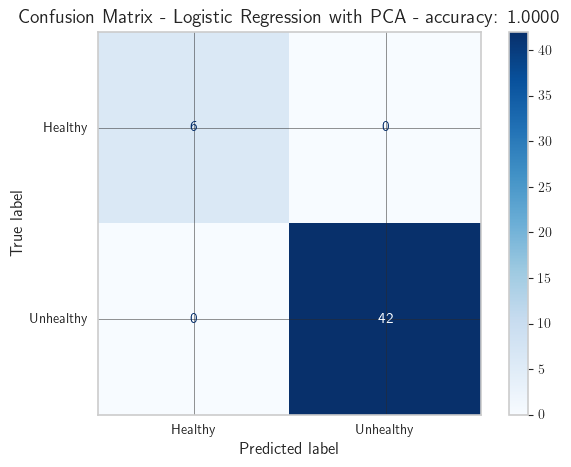

In [8]:
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
# Display the confusion matrix
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix - Logistic Regression with PCA - accuracy: {accuracy_score(y_test, y_pred_best):.4f}')
plt.tight_layout()
plt.show()

### SVM

In [9]:
param_grid = {
    'pca__n_components': [5, 10, 15, 20, 30, 40],
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'svm__degree': [2, 3, 4],
    'svm__class_weight': ['balanced', None]
}

pipeline = Pipeline([    
    ('pca', PCA()),                   
    ('svm', SVC())  
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='balanced_accuracy')

grid_search.fit(X_train, y_train)

print(f"Best cross-validation score (Accuracy): {grid_search.best_score_:.4f}")
print("Best parameters found:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print(f"\nAccuracy on the test set: {accuracy:.4f}")

y_pred_SVM = best_model.predict(X_test)

Fitting 5 folds for each of 4320 candidates, totalling 21600 fits
Best cross-validation score (Accuracy): 1.0000
Best parameters found:
{'pca__n_components': 5, 'svm__C': 1, 'svm__class_weight': 'balanced', 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}

Accuracy on the test set: 1.0000


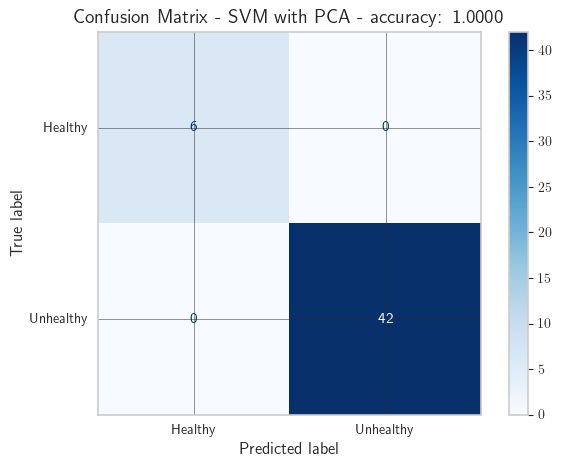

In [10]:
cm = confusion_matrix(y_test, y_pred_SVM)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
# Display the confusion matrix
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix - SVM with PCA - accuracy: {accuracy_score(y_test, y_pred_SVM):.4f}')
plt.tight_layout()
plt.show()

## Classification of Unhealthy plants: Hidric Stress vs fungal diseases (includes combined fungal diseases)

### Data Processing

In [11]:
df_EHvsCombFungus = df1.copy()

df_EHvsCombFungus = df_EHvsCombFungus[(df_EHvsCombFungus['Tratamiento'] != 'Control')]

df_EHvsCombFungus['Tratamiento'] = df_EHvsCombFungus['Tratamiento'].apply(lambda x: 'Fungus_Combined' if x != 'E_Hidrico' else 'Hidric_Stress')

print(df_EHvsCombFungus['Tratamiento'].value_counts())

df_EHvsCombFungus.head()

Tratamiento
Fungus_Combined    179
Hidric_Stress       30
Name: count, dtype: int64


,Tratamiento,Planta,350,351,352,353,354,355,356,357,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
30,Fungus_Combined,1,0.045967,0.041436,0.047575,0.046989,0.044280,0.041682,0.038991,0.039349,...,0.038921,0.038709,0.038491,0.038296,0.038164,0.037970,0.037724,0.037555,0.037394,0.037298
31,Fungus_Combined,2,0.053633,0.050648,0.057949,0.053118,0.047018,0.044844,0.045796,0.046521,...,0.033658,0.033482,0.033324,0.033133,0.032866,0.032687,0.032564,0.032392,0.032223,0.032051
32,Fungus_Combined,3,0.062055,0.059616,0.064222,0.061381,0.057837,0.055202,0.051088,0.052646,...,0.033879,0.033709,0.033514,0.033304,0.032950,0.032804,0.032792,0.032676,0.032612,0.032532
33,Fungus_Combined,4,0.058219,0.053641,0.057320,0.055591,0.053384,0.051206,0.046451,0.048358,...,0.033762,0.033618,0.033543,0.033376,0.033092,0.032943,0.032837,0.032726,0.032680,0.032620
34,Fungus_Combined,5,0.048438,0.045898,0.051811,0.049622,0.046042,0.044055,0.042995,0.044058,...,0.027912,0.027745,0.027652,0.027470,0.027226,0.027036,0.026775,0.026725,0.026867,0.026815


In [12]:
X = df_EHvsCombFungus.iloc[:, 3:].values
y = df_EHvsCombFungus['Tratamiento'].values

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Logistic Regression

In [13]:
# Define a more comprehensive parameter grid for hyperparameter tuning
param_grid = [
    # L1 regularization options
    {
        'PCA__n_components': [5, 10, 15, 20, 30],
        'model__penalty': ['l1'],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'saga'],
        'model__class_weight': [None, 'balanced']
    },
    # L2 regularization options
    {
        'PCA__n_components': [5, 10, 15, 20, 30],
        'model__penalty': ['l2'],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'saga', 'lbfgs'],
        'model__class_weight': [None, 'balanced']
    },
    # Elasticnet option (saga only)
    {
        'PCA__n_components': [5, 10, 15, 20, 30],
        'model__penalty': ['elasticnet'],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__solver': ['saga'],
        'model__l1_ratio': [0.2, 0.5, 0.8],
        'model__class_weight': [None, 'balanced']
    }
]

# Create a pipeline
pipeline = Pipeline([
    ('PCA', PCA()),
    ('model', LogisticRegression(max_iter=1000))
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
# Make predictions with the best model
y_pred_best = best_model.predict(X_test)
# Evaluate the best model
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print("Best Model Classification Report:\n", classification_report(y_test, y_pred_best))

Best Model Accuracy: 0.9047619047619048
Best Model Classification Report:
                  precision    recall  f1-score   support

Fungus_Combined       0.97      0.92      0.94        36
  Hidric_Stress       0.62      0.83      0.71         6

       accuracy                           0.90        42
      macro avg       0.80      0.88      0.83        42
   weighted avg       0.92      0.90      0.91        42



In [14]:
# Parameter for the best model found
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'PCA__n_components': 20, 'model__C': 100, 'model__class_weight': 'balanced', 'model__penalty': 'l1', 'model__solver': 'liblinear'}


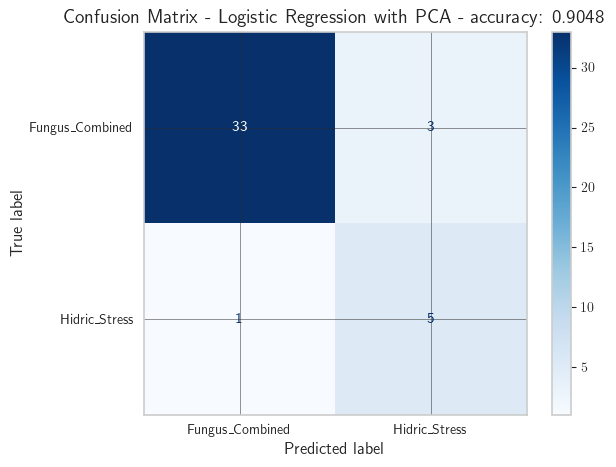

In [15]:
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
# Display the confusion matrix
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix - Logistic Regression with PCA - accuracy: {accuracy_score(y_test, y_pred_best):.4f}')
plt.tight_layout()
plt.show()

## Classification of Unhealthy plants: Hidric Stress vs specific fungal diseases

### Data Processing

In [16]:
df_EHvsFD = df1.copy()

df_EHvsFD = df_EHvsFD[(df_EHvsFD['Tratamiento'] == 'Fusarium') | 
                      (df_EHvsFD['Tratamiento'] == 'E_Hidrico') | 
                      (df_EHvsFD['Tratamiento'] == 'Ralstonia')]  

df_EHvsFD['Tratamiento'] = df_EHvsFD['Tratamiento'].apply(lambda x: 'Fungus_Disease' if x == 'Fusarium' or x == 'Ralstonia' else 'Hydric_Stress')

print(df_EHvsFD['Tratamiento'].unique())

X = df_EHvsFD.iloc[:, 3:].values
y = df_EHvsFD['Tratamiento'].values

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

['Fungus_Disease' 'Hydric_Stress']


### Logistic Regression

In [17]:
# Define a more comprehensive parameter grid for hyperparameter tuning
param_grid = [
    # L1 regularization options
    {
        'PCA__n_components': [5, 10, 15, 20, 30],
        'model__penalty': ['l1'],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'saga'],
        'model__class_weight': [None, 'balanced']
    },
    # L2 regularization options
    {
        'PCA__n_components': [5, 10, 15, 20, 30],
        'model__penalty': ['l2'],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'saga', 'lbfgs'],
        'model__class_weight': [None, 'balanced']
    },
    # Elasticnet option (saga only)
    {
        'PCA__n_components': [5, 10, 15, 20, 30],
        'model__penalty': ['elasticnet'],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__solver': ['saga'],
        'model__l1_ratio': [0.2, 0.5, 0.8],
        'model__class_weight': [None, 'balanced']
    }
]

# Create a pipeline
pipeline = Pipeline([
    ('PCA', PCA()),
    ('model', LogisticRegression(max_iter=1000))
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
# Make predictions with the best model
y_pred_best = best_model.predict(X_test)
# Evaluate the best model
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print("Best Model Classification Report:\n", classification_report(y_test, y_pred_best))

Best Model Accuracy: 0.7777777777777778
Best Model Classification Report:
                 precision    recall  f1-score   support

Fungus_Disease       0.83      0.83      0.83        12
 Hydric_Stress       0.67      0.67      0.67         6

      accuracy                           0.78        18
     macro avg       0.75      0.75      0.75        18
  weighted avg       0.78      0.78      0.78        18



In [18]:
# Parameter for the best model found
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'PCA__n_components': 30, 'model__C': 100, 'model__class_weight': None, 'model__penalty': 'l1', 'model__solver': 'liblinear'}


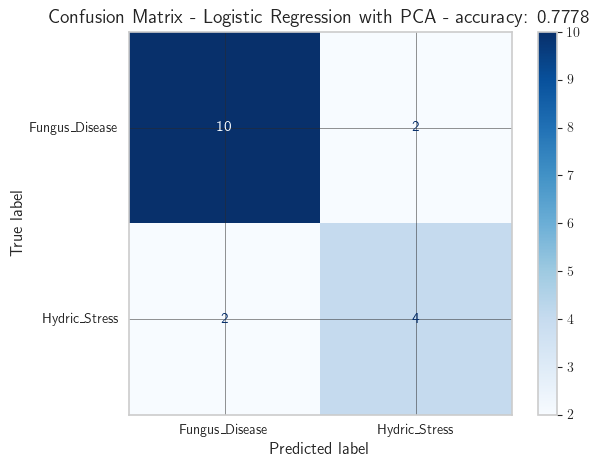

In [19]:
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
# Display the confusion matrix
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix - Logistic Regression with PCA - accuracy: {accuracy_score(y_test, y_pred_best):.4f}')
plt.tight_layout()
plt.show()

## Classification of Unhealthy plants: Ralstonia vs Fusarium

#### Data processing for classification

In [20]:

df_DiseaseType = df1.copy()

# Lets filter only unhealthy plants
df_DiseaseType = df_DiseaseType[(df_DiseaseType['Tratamiento'] == 'Ralstonia') | (df_DiseaseType['Tratamiento'] == 'Fusarium')]

print(df_DiseaseType['Tratamiento'].value_counts())
df_DiseaseType.head()

Tratamiento
Fusarium     30
Ralstonia    29
Name: count, dtype: int64


,Tratamiento,Planta,350,351,352,353,354,355,356,357,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
30,Ralstonia,1,0.045967,0.041436,0.047575,0.046989,0.044280,0.041682,0.038991,0.039349,...,0.038921,0.038709,0.038491,0.038296,0.038164,0.037970,0.037724,0.037555,0.037394,0.037298
31,Ralstonia,2,0.053633,0.050648,0.057949,0.053118,0.047018,0.044844,0.045796,0.046521,...,0.033658,0.033482,0.033324,0.033133,0.032866,0.032687,0.032564,0.032392,0.032223,0.032051
32,Ralstonia,3,0.062055,0.059616,0.064222,0.061381,0.057837,0.055202,0.051088,0.052646,...,0.033879,0.033709,0.033514,0.033304,0.032950,0.032804,0.032792,0.032676,0.032612,0.032532
33,Ralstonia,4,0.058219,0.053641,0.057320,0.055591,0.053384,0.051206,0.046451,0.048358,...,0.033762,0.033618,0.033543,0.033376,0.033092,0.032943,0.032837,0.032726,0.032680,0.032620
34,Ralstonia,5,0.048438,0.045898,0.051811,0.049622,0.046042,0.044055,0.042995,0.044058,...,0.027912,0.027745,0.027652,0.027470,0.027226,0.027036,0.026775,0.026725,0.026867,0.026815


In [21]:
# data treatment

# Data preparation for model production
X = df_DiseaseType.iloc[:, 3:].values

y = df_DiseaseType['Tratamiento'].values

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Logistic Regression

In [22]:
# Define a more comprehensive parameter grid for hyperparameter tuning
param_grid = [
    # L1 regularization options
    {
        'PCA__n_components': [5, 10, 15, 20, 30],
        'model__penalty': ['l1'],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'saga'],
        'model__class_weight': [None, 'balanced']
    },
    # L2 regularization options
    {
        'PCA__n_components': [5, 10, 15, 20, 30],
        'model__penalty': ['l2'],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'saga', 'lbfgs'],
        'model__class_weight': [None, 'balanced']
    },
    # Elasticnet option (saga only)
    {
        'PCA__n_components': [5, 10, 15, 20, 30],
        'model__penalty': ['elasticnet'],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__solver': ['saga'],
        'model__l1_ratio': [0.2, 0.5, 0.8],
        'model__class_weight': [None, 'balanced']
    }
]

# Create a pipeline
pipeline = Pipeline([
    ('PCA', PCA()),
    ('model', LogisticRegression(max_iter=1000))
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
# Make predictions with the best model
y_pred_best = best_model.predict(X_test)
# Evaluate the best model
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print("Best Model Classification Report:\n", classification_report(y_test, y_pred_best))


Best Model Accuracy: 0.9166666666666666
Best Model Classification Report:
               precision    recall  f1-score   support

    Fusarium       0.86      1.00      0.92         6
   Ralstonia       1.00      0.83      0.91         6

    accuracy                           0.92        12
   macro avg       0.93      0.92      0.92        12
weighted avg       0.93      0.92      0.92        12



c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [23]:
# Parameter for the best model found
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'PCA__n_components': 10, 'model__C': 100, 'model__class_weight': None, 'model__penalty': 'l1', 'model__solver': 'saga'}


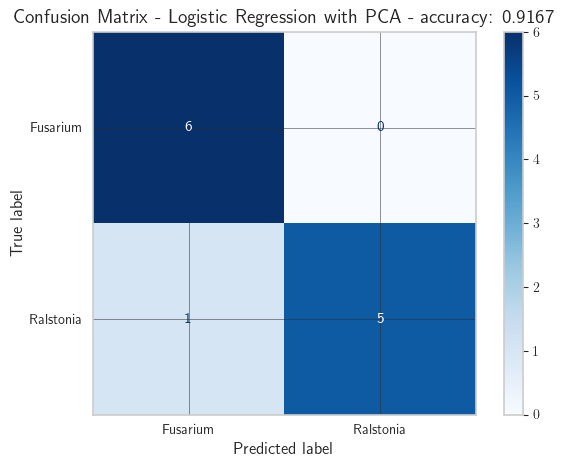

In [24]:
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
# Display the confusion matrix
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix - Logistic Regression with PCA - accuracy: {accuracy_score(y_test, y_pred_best):.4f}')
plt.tight_layout()
plt.show()